In [1]:
# Python imports

import matplotlib.pyplot as plt

## Wrangle.py Functions:

### Wrangle Imports

In [2]:
import pandas as pd
import numpy as np
import json

### encoder_dictionary

In [3]:
# declare rules for encoding
encoder_dictionary = {
    "important5": {
        "Not at all Important" : 0,
        "Somewhat Important" : 1,
        "Neutral" : 2,
        "Important" : 3,
        "Very Important": 4,
        np.NaN: None
    },
    'likely5': {
        'Extremely unlikely' : 0,
        'Unlikely' : 1,
        'Neutral' : 2,
        'Likely' : 3,
        'Extremely likely': 4,
        np.NaN: None
    },
    "often4": {
        "Never": 0,
        "Rarely": 1,
        "Sometimes": 2,
        "Often": 3,
        np.NaN: None
    },
    "often5": {
        "Never": 0,
        "Occasionally": 1,
        "Neutral": 2,
        "Often": 3,
        "All or almost all": 4,
        np.NaN: None
    },
    "q03_cats": {
        "1-25 employees": 0,
        "26-100 employees": 1, 
        "101-500 employees": 2,
        "501-1,000 employees": 3,
        "1,000+ employees": 4,
        np.NaN: None
    },
    "q04_cats": {
        "1-5 employees": 0,
        "6-10 employees": 1,
        "11-50 employees": 2,
        "50+ employees": 3,
        np.NaN: None
    },
    "q09a_cats": {
        "Yes, I was taught how to conduct research ": 1,
        "No, I was not taught how to conduct research": 2,
    },
    "q17a_cats": {
        "Retreat/workshop: < 50 attendees": 1,
        "Small conference: < 300 attendees ": 2,
        "Mid-size conference : 300-500 attendees": 3,
        "Large conference: 500+ attendees": 4,
        "No preference": 6,
        "It Depends": 7,
        "Virtual": 8,
    },
    "q18_cats": {
        "Single-Track": 1,
        "Multi-Track": 2,
        "Unconference": 3,
        "Mixed-Type": 4,
        "No Preference": 5,
    },
    "tenure6": {
        "0-1 year": 0,
        "1-3 years": 1,
        "3-5 years": 2,
        "5-7 years": 3,
        "7-10 years": 4,
        "10+ years": 5,
        np.NaN: None
    },
    "yesno10": {
        "Yes": 1,
        "No": 0,
    }

}



### join_files

In [4]:
join_files = {
    'q09a': 'data_files/q09_to_categories.txt',
    'q17a': 'data_files/q17_to_categories.txt',
    'q18a': 'data_files/q18_to_categories.txt',
}

### get_labels

In [5]:
def get_labels(x):
    '''
    assigns subjects to persona groups based on their job title and years of reaearch

    use with df.apply(get_labels, axis = 1) and make sure the 'id_col' is set to what ever the 'Job Taxo ID' column is names and the 'max_experience' is derrived from other functions

    args: x - pandas datafram row
    returns: pandas series of persona ids
    '''
    #taxo ids we assume indicate personas
    exec_and_consult_ids = [7,8]
    specialist_ids = [3,4,5,9]
    other_ids = [1,2,6]

    #open variable for calling id column, coded this way for easy change should we rename the columns
    id_col = 'q01b'
    experience_col = 'research_years'

    #assign persona classifiers based on their taxo id first followed by their max years of experience
    if x[id_col] in exec_and_consult_ids:
        return 1
    if x[id_col] in specialist_ids:
        return 2
    if x[id_col] in other_ids:
        if x[experience_col] in [5]:
            return 3
        if x[experience_col] in [2,3,4]:
            return 4
        if x[experience_col] in [0,1]:
            return 5
    ### return a null if no conditions are met
    return np.nan



### get_max_research_years

In [6]:
def get_max_research_years(df):
    '''
    function takes in dataframe, grabs all columns pertaining to research years (q2:a-j) encodes them and labels subject the value from the column with the higest value

    args: df - pandas dataframe
    returns: max_research - pandas series
    '''
    #define columns that describe subject's research experience
    research_columns = ['q08a', 'q08b','q08c', 'q08d', 'q08e', 
                        'q08f', 'q08g', 'q08h', 'q08i', 'q08j']
        
    max_research = df[research_columns].apply(max, axis = 1)
    return max_research
    


### get_data_dictionary

In [7]:
# get data dictionary

def get_data_dictionary(path_prefix='', dictionary_path='data_files/data_dictionary.xlsx'):
    data_dictionary = pd.read_excel(path_prefix + dictionary_path).set_index('qid').sort_index()
    return data_dictionary



### get_mapping_dictionary

In [8]:
def get_mapping_dictionary(data_dictionary):
    map_df = data_dictionary[['encoder']].dropna()
    map_df['col'] = map_df.index
    return map_df

### mapping dictionary

In [9]:
# # read mapping dictionary from question_library to map rules to corresponding columns
# map_df = pd.read_csv('../kev/question_library.txt').dropna().set_index('qid2')
# map_df['col'] = map_df.index

### encode_columns

In [10]:
def encode_columns(df, map_df, encoder=encoder_dictionary):
    '''

    '''
    allcols=map_df.col
    check_dicts=map_df.encoder
    cols=[chkcol for chkcol in allcols if chkcol in df.columns]
    
    for col in cols:
        use_dict = encoder[check_dicts[col]]
        encoded = df[col].apply(lambda x: use_dict[x])
        df[col] = encoded
    return df



### append_join_files

In [106]:
def append_join_files(df, reqd_cols, path_prefix='', join_files=join_files):
    chk_cols = [col for col in reqd_cols if col in df.columns]
#     print('non-null rows',df[chk_cols].dropna().shape)
    for key in join_files:
        file_path = join_files[key]
#         print("joining", key)
        join_df = pd.read_csv(path_prefix + file_path).set_index('q00')
        df = df.join(join_df)
        chk_cols = [col for col in reqd_cols if col in df.columns]
#         print('non-null rows',df[chk_cols].dropna().shape)
    return df

### impute_09

In [110]:
def impute_q09(df):
#     print(df.columns)
    re_adds = (df[[
        'q09a',
        'q09b',
        'q10',
    ]][
        (df.q09a.isna()) & 
        (df.q10.isna()==False)
    ])
    re_add_idxs = re_adds.index.tolist()
    for idx in re_add_idxs:
        df.loc[idx, 'q09a'] = 'Imputed Yes'
        df.loc[idx, 'q09b'] = 1
    return df
    


### drop_reqd_nas

In [123]:
def drop_reqd_nas(df, reqd_cols):
#     print(df.shape)
    chk_cols = [col for col in reqd_cols if col in df.columns]
    na_df = df[chk_cols].copy()
    na_df['nulls'] = na_df.isna().sum(axis=1)
    df = df.join(na_df[['nulls']])
#     print(na_df.shape)
#     na_df = na_df.dropna()
#     print(na_df.shape)
    df=df[df.nulls==0].drop(columns=['nulls'])
#     print(df.shape)
    
    return df

### reset_columns_types

In [168]:
def reset_column_types(df, data_dictionary):
    chk_cols = data_dictionary[['column_name', 'data_type']].set_index('column_name')
#     chk_cols['col'] = chk_cols.index
    display(chk_cols)
#     set_cols = chk_cols[chk_cols.col in df.columns]
#     display(set_cols)
    set_dict = chk_cols.to_dict()['data_type']
    print(set_dict)
    pops = []
    for key in set_dict:
        if key not in df.columns:
            pops.append(key)
            print(key, 'popped')
    for pop in pops:
        set_dict.pop(pop)
    df = df.astype(set_dict)
    return df

### wrangle_data

In [169]:
def wrangle_data(
    path_prefix='../', 
    data_path = 'data_files/survey_responses.xlsx',
    dictionary_path = 'data_files/data_dictionary.xlsx',
    encoder=encoder_dictionary,
    join_files=join_files
):
    '''
    reads data from survey_responses.xlsx and applies the following transformations:
        - encodes categoriacal variables
        - calculates and applies persona labels
        - assigns more descritive names for columns from data_dictionary

    args: None
    returns: pandas DataFrame
    '''
    # Get data
    data = pd.read_excel(path_prefix + data_path)
    data['idx'] = data.q00
    data.set_index('idx', inplace = True)
    
    # Get data dictionary
    data_dictionary = get_data_dictionary(path_prefix, dictionary_path=dictionary_path)
    
    #Set encoder map
    map_df = get_mapping_dictionary(data_dictionary=data_dictionary)
    
    # Encode columns
    encode_columns(data, map_df=map_df, encoder=encoder, )
    
    # Append join columns
    reqd_cols = data_dictionary.index[(data_dictionary.is_required)]
    reqd_cols = reqd_cols[reqd_cols != data.index.name]
    data = append_join_files(data, reqd_cols=reqd_cols, path_prefix=path_prefix, join_files=join_files)
    
    # Impute missing q09 values from q10
    data = impute_q09(data)
    
    # Drop required NAs
    data = drop_reqd_nas(data, reqd_cols=reqd_cols)
    
    # Find max research years to be used in label category
    research_years = get_max_research_years(data)

    # Apply labels
    data['persona_id'] = (
        data
        .join(pd.DataFrame(research_years, columns=['research_years']))
        .apply(get_labels, axis=1)
        )

    # Update column names from data dictionary
    data.rename(columns = data_dictionary.column_name, inplace = True)
    data = data[data_dictionary.column_name]
    
    # Set index
    data.set_index('resp_id', inplace = True)

    # Reset Column Types
    data = reset_column_types(data, data_dictionary=data_dictionary)
    
    return data, data_dictionary


In [170]:
# Get wrangle file

datadf, dictionarydf = wrangle_data(path_prefix='../')

,data_type
column_name,
resp_id,int64
job_title,category
job_taxo,category
job_id,category
job_conduct_res,int64
job_analyze_res,int64
job_buy_res_report,int64
job_manage_res_proj,int64
job_observe_res,int64


{'resp_id': 'int64', 'job_title': 'category', 'job_taxo': 'category', 'job_id': 'category', 'job_conduct_res': 'int64', 'job_analyze_res': 'int64', 'job_buy_res_report': 'int64', 'job_manage_res_proj': 'int64', 'job_observe_res': 'int64', 'job_plan_res': 'int64', 'job_teach_res': 'int64', 'job_advocate_res': 'int64', 'job_hire_res_vendor': 'int64', 'job_lead_res_team': 'int64', 'num_employees': 'category', 'num_researchers': 'category', 'primary_industry': 'category', 'types_res_used': 'category', 'future_res': 'category', 'exp_conduct_res': 'int64', 'exp_analyze_res': 'int64', 'exp_buy_res_report': 'int64', 'exp_manage_res_proj': 'int64', 'exp_observe_res': 'int64', 'exp_plan_res': 'int64', 'exp_teach_res': 'int64', 'exp_advocate_res': 'int64', 'exp_hire_res_vendor': 'int64', 'exp_lead_res_team': 'int64', 'research_educ': 'object', 'research_educ_cat': 'category', 'research_educ_desc': 'object', 'learning_talks': 'int64', 'learning_read': 'int64', 'learning_meetup': 'int64', 'learning

In [171]:
display(datadf)

,job_title,job_taxo,job_id,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,...,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables,other_conference_types,ideal_topics,ideal_attendees,recommendations,persona_id
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,1.0,3,2,0,3,3,3,3,...,2,3,2,2,2,NaN,research-practice connections,NaN,research-practice connections,2
288,Academic,4,1.0,1,2,1,3,3,3,3,...,3,3,1,1,2,NaN,NaN,NaN,Don’t create schedule conflicts with other rel...,2
294,Academic,4,1.0,3,3,1,3,1,3,3,...,2,2,2,2,2,NaN,NaN,NaN,Looking forward! \n,2
281,Academic,4,1.0,3,4,0,2,3,2,0,...,3,2,2,3,2,NaN,"Research design, innovative methods, communica...",NaN,NaN,2
280,Academic,4,1.0,3,3,0,1,1,3,2,...,3,2,1,2,2,You should consider the combination of confere...,NaN,NaN,NaN,2
295,Academic,4,1.0,3,4,1,3,1,3,4,...,3,3,1,3,4,NaN,NaN,"I like a mix, academics and professionals, qua...",I actually feel like the biggest contribution ...,2
291,Academic,4,1.0,3,3,0,3,3,3,3,...,2,3,1,2,3,NaN,"design, participatory analysis,","companies, academic researchers, public policy...",NaN,2
290,Academic,4,1.0,3,3,1,3,4,4,3,...,2,2,0,1,4,NaN,Sessions about new methodologies or cases studies,Leading researchers,Go ahead! Your prestige is a guaranty,2
296,Academic,4,1.0,3,3,0,3,1,3,4,...,4,3,2,2,2,Nope! Only to say that sometimes workshops on ...,Sampling and participant recruitment; Strategi...,People who are known to have developed skill s...,It would be nice to have more conferences that...,2


In [172]:
display(dictionarydf)

,column_name,is_required,from_orig_file,in_wrangle,char_type,function,data_type,encoder,survey_section,question_group,question_text
qid,,,,,,,,,,,
q00,resp_id,True,True,True,numeric,identification,int64,NaN,Survey,ID,Entry Id
q01a,job_title,True,True,True,text,categorical,category,NaN,Work,Position,Title
q01b,job_taxo,True,True,True,numeric,categorical,category,NaN,Work,Position,Job Taxo ID
q01c,job_id,False,True,True,numeric,categorical,category,NaN,Work,Position,Job ID
q02a,job_conduct_res,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Conducting Research
q02b,job_analyze_res,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Analyzing Research
q02c,job_buy_res_report,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Buying Research Reports
q02d,job_manage_res_proj,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Managing Research Projects
q02e,job_observe_res,True,True,True,numeric,quantitative,int64,often5,Work,Research Duties,Observing Research


In [173]:
datadf.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 284 to 2
Data columns (total 78 columns):
job_title                         726 non-null category
job_taxo                          726 non-null category
job_id                            723 non-null category
job_conduct_res                   726 non-null int64
job_analyze_res                   726 non-null int64
job_buy_res_report                726 non-null int64
job_manage_res_proj               726 non-null int64
job_observe_res                   726 non-null int64
job_plan_res                      726 non-null int64
job_teach_res                     726 non-null int64
job_advocate_res                  726 non-null int64
job_hire_res_vendor               726 non-null int64
job_lead_res_team                 726 non-null int64
num_employees                     723 non-null category
num_researchers                   722 non-null category
primary_industry                  726 non-null category
types_res_used               

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 284 to 2
Data columns (total 78 columns):
job_title                         868 non-null object
job_taxo                          868 non-null int64
job_id                            865 non-null float64
job_conduct_res                   868 non-null int64
job_analyze_res                   868 non-null int64
job_buy_res_report                868 non-null int64
job_manage_res_proj               868 non-null int64
job_observe_res                   868 non-null int64
job_plan_res                      868 non-null int64
job_teach_res                     868 non-null int64
job_advocate_res                  868 non-null int64
job_hire_res_vendor               868 non-null int64
job_lead_res_team                 868 non-null int64
num_employees                     865 non-null float64
num_researchers                   862 non-null float64
primary_industry                  868 non-null object
types_res_used                    808 n

## Data Dictionary

In [22]:
map_df = pd.read_excel('../data_files/data_dictionary.xlsx').set_index('qid').sort_index()
# map_df['col'] = map_df.index

In [23]:
data_dictionary = get_data_dictionary(path_prefix='../')
display(data_dictionary)

,column_name,is_required,from_orig_file,in_wrangle,char_type,function,encoder,survey_section,question_group,question_text
qid,,,,,,,,,,
q00,resp_id,True,True,True,numeric,identification,NaN,Survey,ID,Entry Id
q01a,job_title,True,True,True,text,categorical,NaN,Work,Position,Title
q01b,job_taxo,True,True,True,numeric,categorical,NaN,Work,Position,Job Taxo ID
q01c,job_id,False,True,True,numeric,categorical,NaN,Work,Position,Job ID
q02a,job_conduct_res,True,True,True,numeric,quantitative,often5,Work,Research Duties,Conducting Research
q02b,job_analyze_res,True,True,True,numeric,quantitative,often5,Work,Research Duties,Analyzing Research
q02c,job_buy_res_report,True,True,True,numeric,quantitative,often5,Work,Research Duties,Buying Research Reports
q02d,job_manage_res_proj,True,True,True,numeric,quantitative,often5,Work,Research Duties,Managing Research Projects
q02e,job_observe_res,True,True,True,numeric,quantitative,often5,Work,Research Duties,Observing Research


In [24]:
display(data_dictionary.info())

<class 'pandas.core.frame.DataFrame'>
Index: 79 entries, q00 to x01
Data columns (total 10 columns):
column_name       79 non-null object
is_required       79 non-null bool
from_orig_file    79 non-null bool
in_wrangle        79 non-null bool
char_type         79 non-null object
function          79 non-null object
encoder           59 non-null object
survey_section    78 non-null object
question_group    78 non-null object
question_text     78 non-null object
dtypes: bool(3), object(7)
memory usage: 5.2+ KB


None

In [25]:
map_df = get_mapping_dictionary(data_dictionary=data_dictionary)

In [26]:
# cur_columns = datadf.columns
required_columns = data_dictionary.column_name[(data_dictionary.is_required)].tolist()[1:]
# reqd_columns = reqd_columns[reqd_columns != datadf.index.name]
required_columns

['job_title',
 'job_taxo',
 'job_conduct_res',
 'job_analyze_res',
 'job_buy_res_report',
 'job_manage_res_proj',
 'job_observe_res',
 'job_plan_res',
 'job_teach_res',
 'job_advocate_res',
 'job_hire_res_vendor',
 'job_lead_res_team',
 'primary_industry',
 'exp_conduct_res',
 'exp_analyze_res',
 'exp_buy_res_report',
 'exp_manage_res_proj',
 'exp_observe_res',
 'exp_plan_res',
 'exp_teach_res',
 'exp_advocate_res',
 'exp_hire_res_vendor',
 'exp_lead_res_team',
 'research_educ',
 'research_educ_cat',
 'learning_talks',
 'learning_read',
 'learning_meetup',
 'learning_workshop',
 'learning_conference',
 'likely_watch_video',
 'likely_internet',
 'likely_book',
 'likely_online_group',
 'likely_colleague',
 'likely_meetup',
 'likely_conference',
 'likely_workshop',
 'factor_speaker',
 'factor_diverse_speak',
 'factor_topics',
 'factor_format_sessions',
 'factor_size',
 'factor_network',
 'factor_variety_attend',
 'factor_code',
 'factor_location',
 'factor_ability_to_pay',
 'ideal_confere

In [27]:
datadf[required_columns].dropna().shape

(726, 60)

In [28]:
na_df = datadf[required_columns]
na_df

,job_title,job_taxo,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,job_advocate_res,...,ideal_structure,ideal_structure_cat,session_keynote,session_long_talk,session_short_talk,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,3,2,0,3,3,3,3,2,...,"any, depending on the values",5.0,4.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
288,Academic,4,1,2,1,3,3,3,3,3,...,Multi-track: Every attendee chooses their own ...,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0
294,Academic,4,3,3,1,3,1,3,3,3,...,It depends,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
281,Academic,4,3,4,0,2,3,2,0,1,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0
280,Academic,4,3,3,0,1,1,3,2,1,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,2.0,3.0,3.0,2.0,1.0,2.0,2.0
295,Academic,4,3,4,1,3,1,3,4,1,...,Multi-track: Every attendee chooses their own ...,2.0,2.0,4.0,3.0,3.0,3.0,1.0,3.0,4.0
291,Academic,4,3,3,0,3,3,3,3,3,...,Multi-track: Every attendee chooses their own ...,2.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0
290,Academic,4,3,3,1,3,4,4,3,2,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,4.0,1.0,2.0,2.0,0.0,1.0,4.0
296,Academic,4,3,3,0,3,1,3,4,3,...,Single-track: All attendees experience the sam...,1.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0,2.0


In [29]:
na_df_dropped=na_df.dropna()
na_df_dropped

,job_title,job_taxo,job_conduct_res,job_analyze_res,job_buy_res_report,job_manage_res_proj,job_observe_res,job_plan_res,job_teach_res,job_advocate_res,...,ideal_structure,ideal_structure_cat,session_keynote,session_long_talk,session_short_talk,session_workshop,session_network,session_social_event,session_qa,sesson_topic_tables
resp_id,,,,,,,,,,,,,,,,,,,,,
284,Academic,4,3,2,0,3,3,3,3,2,...,"any, depending on the values",5.0,4.0,2.0,2.0,2.0,3.0,2.0,2.0,2.0
288,Academic,4,1,2,1,3,3,3,3,3,...,Multi-track: Every attendee chooses their own ...,2.0,3.0,3.0,3.0,3.0,3.0,1.0,1.0,2.0
294,Academic,4,3,3,1,3,1,3,3,3,...,It depends,5.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0,2.0
281,Academic,4,3,4,0,2,3,2,0,1,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,2.0,3.0,3.0,2.0,2.0,3.0,2.0
280,Academic,4,3,3,0,1,1,3,2,1,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,2.0,3.0,3.0,2.0,1.0,2.0,2.0
295,Academic,4,3,4,1,3,1,3,4,1,...,Multi-track: Every attendee chooses their own ...,2.0,2.0,4.0,3.0,3.0,3.0,1.0,3.0,4.0
291,Academic,4,3,3,0,3,3,3,3,3,...,Multi-track: Every attendee chooses their own ...,2.0,3.0,3.0,2.0,2.0,3.0,1.0,2.0,3.0
290,Academic,4,3,3,1,3,4,4,3,2,...,Multi-track: Every attendee chooses their own ...,2.0,4.0,4.0,1.0,2.0,2.0,0.0,1.0,4.0
296,Academic,4,3,3,0,3,1,3,4,3,...,Single-track: All attendees experience the sam...,1.0,3.0,3.0,2.0,4.0,3.0,2.0,2.0,2.0


In [74]:
na_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 284 to 2
Data columns (total 61 columns):
job_title                    868 non-null object
job_taxo                     868 non-null int64
job_conduct_res              868 non-null int64
job_analyze_res              868 non-null int64
job_buy_res_report           868 non-null int64
job_manage_res_proj          868 non-null int64
job_observe_res              868 non-null int64
job_plan_res                 868 non-null int64
job_teach_res                868 non-null int64
job_advocate_res             868 non-null int64
job_hire_res_vendor          868 non-null int64
job_lead_res_team            868 non-null int64
primary_industry             868 non-null object
exp_conduct_res              824 non-null float64
exp_analyze_res              824 non-null float64
exp_buy_res_report           824 non-null float64
exp_manage_res_proj          824 non-null float64
exp_observe_res              824 non-null float64
exp_plan_res       

In [75]:
na_df_dropped.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 726 entries, 284 to 2
Data columns (total 60 columns):
job_title                    726 non-null object
job_taxo                     726 non-null int64
job_conduct_res              726 non-null int64
job_analyze_res              726 non-null int64
job_buy_res_report           726 non-null int64
job_manage_res_proj          726 non-null int64
job_observe_res              726 non-null int64
job_plan_res                 726 non-null int64
job_teach_res                726 non-null int64
job_advocate_res             726 non-null int64
job_hire_res_vendor          726 non-null int64
job_lead_res_team            726 non-null int64
primary_industry             726 non-null object
exp_conduct_res              726 non-null float64
exp_analyze_res              726 non-null float64
exp_buy_res_report           726 non-null float64
exp_manage_res_proj          726 non-null float64
exp_observe_res              726 non-null float64
exp_plan_res       

In [32]:
# common = df1.merge(df2,on=['col1','col2'])
# (~df1.col1.isin(common.col1))&(~df1.col2.isin(common.col2))

In [33]:
na_df['has_null'] = na_df.isna().sum(axis=1)

/usr/local/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """Entry point for launching an IPython kernel.


In [34]:
na_df[na_df.has_null == 3].T

resp_id
job_title
job_taxo
job_conduct_res
job_analyze_res
job_buy_res_report
job_manage_res_proj
job_observe_res
job_plan_res
job_teach_res
job_advocate_res


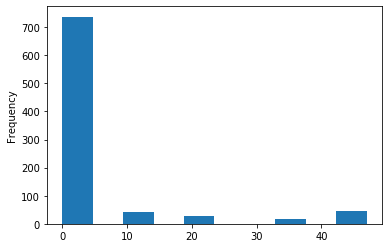

In [35]:
na_df.has_null.plot.hist()

## Mixed Questions

### Q09
***Did any part of your education include learning about how to conduct research?***

In [36]:
q09a = dictionarydf.column_name.loc['q09a']
print(q09a)
q09df = datadf[[q09a]].copy()
q09df = q09df.rename(columns={
    q09a: 'q09a',
})

display(q09df.head())
display(q09df.info())

research_educ


,q09a
resp_id,
284,"sort of, psychology background."
288,"Yes, I was taught how to conduct research"
294,"Yes, I was taught how to conduct research"
281,"Yes, I was taught how to conduct research"
280,"No, I was not taught how to conduct research"


<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 284 to 2
Data columns (total 1 columns):
q09a    855 non-null object
dtypes: object(1)
memory usage: 13.6+ KB


None

In [37]:
q09vc = pd.DataFrame(q09df.q09a.value_counts(dropna=False)).rename(columns={'q09a':'q09vc'})
q09vc.index.name = 'q09v'

In [38]:
q09vc[q09vc.q09vc>5]

,q09vc
q09v,
"Yes, I was taught how to conduct research",577
"No, I was not taught how to conduct research",194
Yes,31
NaN,13


In [39]:
q09a_cats = {
    "Yes, I was taught how to conduct research ": 1,
    "No, I was not taught how to conduct research": 2,
}

In [40]:
q09vc[q09vc.q09vc<5]

,q09vc
q09v,
I had some classes but really picked most of it from Rosenfeld's Leah and Tomer's books.,1
I learned by teaching,1
I was taught some aspects of scientific research but not ux research in particular,1
I taught myself during my PhD,1
"Not my formal education, but I did get mentored by an experienced research professional on all things research, if that counts.",1
"My background is engineering. As an engineer I was trained in conducting scientific research, much of which is transferrable to UX research. I've supplemented this with self-guided learning.",1
learned by doing and also mentor guidance,1
I studied psych. So I guess I was 'taught' how to carry out a psychology experiment.,1
Some of my MA English courses explored UCD,1


### Q17
***What would be the ideal audience size for a conference about research that *you* would want to attend?!***

In [41]:
q17a = dictionarydf.column_name.loc['q17a']
q17b = dictionarydf.column_name.loc['q17b']

print(q17a)
print(q17b)

q17df = datadf[[q17a, q17b]].copy()
q17df = q17df.rename(columns={
    q17a: 'q17a',
    q17b: 'q17b'
})
display(q17df.head())
display(q17df.info())

ideal_conference_size
ideal_conference_size_cat_orig


,q17a,q17b
resp_id,,
284,depending on the professional values,7.0
288,I would attend any of these,6.0
294,It depends - I really enjoyed small conference...,7.0
281,Large conference: 500+ attendees,4.0
280,Large conference: 500+ attendees,4.0


<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 284 to 2
Data columns (total 2 columns):
q17a    737 non-null object
q17b    866 non-null float64
dtypes: float64(1), object(1)
memory usage: 20.3+ KB


None

In [42]:
q17vc = pd.DataFrame(q17df.q17a.value_counts(dropna=False)).rename(columns={'q17a':'q17vc'})
q17vc.index.name = 'q17v'

In [43]:
q17vc[q17vc.q17vc>5]

,q17vc
q17v,
Small conference: < 300 attendees,259
Retreat/workshop: < 50 attendees,193
Mid-size conference : 300-500 attendees,178
NaN,131
Large conference: 500+ attendees,45


In [44]:
q17vc[q17vc.q17vc<5]

,q17vc
q17v,
it doesn't matter,2
No preference,2
"Sorry, it really depends on the context. Hard to pick one.",1
"It really depends. if there are VIPs having talks. I don't expect that conference to be small.. and when it's small, I don't expect VIPs to talk...",1
Retreat to mid-size are all appealing,1
150,1
50-300 attendees,1
"It's hard to pick an ideal size! I'd say 500+ would start to get pretty impersonal, but it really depends what networking opportunities the organisers provide. I've never been to a retreat-style event, but intrigued by this!",1
"There is no idea, it depends on who the other attendees are and how the size affects other things like location/cost etc.",1


In [45]:
q17bgb = q17df.groupby(by=['q17b','q17a']).count()

In [46]:
q17bgb 

Empty DataFrame
Columns: []
Index: [(1.0, Class), (1.0, Retreat/workshop: < 50 attendees), (2.0, 150), (2.0, 50-300 attendees), (2.0, <100), (2.0, I like to 100-120 number most; intimacy and time to dwell on 'stranger things'), (2.0, Small conference: < 300 attendees), (3.0, Mid-size conference : 300-500 attendees), (3.0, Retreat to mid-size are all appealing), (3.0, To be honest, I'm not sure I have one single ideal audience size but im not a fan of overly large, commercialized conferences.... So mostly smaller conferences and workshops are best when I'm trying to deepens my knowledge on a specific methodology), (4.0, 500-750), (4.0, Large conference: 500+ attendees), (6.0, All of these are fine. I can learn in all if them if the courses are constructed to match the size and venue.), (6.0, Any of the above), (6.0, Any size), (6.0, Any size, not fussed), (6.0, Audience size doesn't matter), (6.0, Doesn't matter?), (6.0, Don't matter the size), (6.0, Don’t have a preference), (6.0, I don't care about the size), (6.0, I don't care as long as I actually learn something. Not intro content.), (6.0, I don't consider this an important factor), (6.0, I don't mind at all), (6.0, I don't really think size is a decisive factor... I can imagine amazing event in small and also in large scale), (6.0, I honestly don't care about size comparative to contenr), (6.0, I really don’t have a preference), (6.0, I will consider any size of conference), (6.0, I would attend any of these), (6.0, I'm not sure that number of attendees would be an influencing factor - other factors are more important to me), (6.0, I'm open to anything. I like the small retreats and small conferences for their intimacy but sometimes I want the options of a large conference.), (6.0, It doesn’t matter, content is the king ), (6.0, It is not important the size), (6.0, No preference), (6.0, Not a variable that would affect my decision), (6.0, Number of people isn't my only consideration it's mainly location and cost. I would be happy with all of the above.), (6.0, Size doesn’t matter to me), (6.0, Size isn't important), (6.0, This does not factor in to my decision.), (6.0, it doesn't matter), (6.0, no ideal size, but <100 could be interesting), (6.0, no preference on size), (7.0, Depends on what I want to learn and how intensely), (7.0, Honestly a mis of retreat-mid size), (7.0, I chose Other, when I really wanted to choose retreat but NOT workshop, I think those are very different. My experience with workshops is being led through a bunch of predetermined exercises whereas at a retreat I'd imagine having space to explore ), (7.0, I like large conferences for inspiration. Like the idea of a retreat for specialist learning. Assume it's too expensive), (7.0, It depends - I really enjoyed small conferences as IXDA Education Summit as there is great opportunity to network with other educators. On the other side, sometimes is great just to attend big conference to find an inspiration or just to meet coll...), (7.0, It depends on how it's planned), (7.0, It really depends. if there are VIPs having talks. I don't expect that conference to be small.. and when it's small, I don't expect VIPs to talk...), (7.0, It's hard to pick an ideal size! I'd say 500+ would start to get pretty impersonal, but it really depends what networking opportunities the organisers provide. I've never been to a retreat-style event, but intrigued by this!), (7.0, No opinion - it all depends on the quality of the topics and speakers), (7.0, Size depends on intent. If learning new skill and majority of learning is from official conf content, small is great. But most times I learn far more from diverse people met rather than official content.), (7.0, Size matters for learning topics, but not networking and inspiration.), (7.0, Small or Large for different reasons), (7.0, Sorry, it really depends on the context. Hard to pick one. ), (7.0, The right balance between cost and number of attendees), (7.0, There is no 

In [47]:
q17a_cats = {
    "Retreat/workshop: < 50 attendees": 1,
    "Small conference: < 300 attendees ": 2,
    "Mid-size conference : 300-500 attendees": 3,
    "Large conference: 500+ attendees": 4,
    "No preference": 6,
    "It Depends": 7,
    "Virtual": 8,
}

### Q18
***What would be the ideal structure for a conference about research that*** **you** ***would want to attend?!***

In [48]:
q18a = dictionarydf.column_name.loc['q18a']
print(q18a)
q18df = datadf[[q18a]].copy()
q18df = q18df.rename(columns={
    q18a: 'q18a',
})
                     
display(q18df.head())
display(q18df.info())

ideal_structure


,q18a
resp_id,
284,"any, depending on the values"
288,Multi-track: Every attendee chooses their own ...
294,It depends
281,Multi-track: Every attendee chooses their own ...
280,Multi-track: Every attendee chooses their own ...


<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 284 to 2
Data columns (total 1 columns):
q18a    737 non-null object
dtypes: object(1)
memory usage: 13.6+ KB


None

In [49]:
q18vc = pd.DataFrame(q18df.q18a.value_counts(dropna=False)).rename(columns={'q18a':'q18vc'})
q18vc.index.name = 'q18v'

In [50]:
q18vc[q18vc.q18vc>5]

,q18vc
q18v,
Multi-track: Every attendee chooses their own path with multiple options available for most time-slots,438
Single-track: All attendees experience the same content at the same time,226
NaN,131
Unconference: Attendees bring the content and the schedule emerges from who wants to present,32


In [51]:
q18a_cats = {
    "Multi-track: Every attendee chooses their own path with multiple options available for most time-slots": 1,
    "Single-track: All attendees experience the same content at the same time": 2,
    "Unconference: Attendees bring the content and the schedule emerges from who wants to present": 3,
    "Other": 4,
}

In [52]:
q18vc[q18vc.q18vc<5]

,q18vc
q18v,
"Combo of UnConf and workshops. Fewer talks, more hands-on.",1
"any, depending on the values",1
The problem with multi-track is you can often miss something you want to attand whilst at an other talk - offering multiple times for a session would be best,1
Combo single-track/unconference,1
"Anything except the ""unconference"". When I am there to learn, it is most efficient for the organizes to structure it to deliver the learning experiences for optimal benefit. (And face it, most people are not great instructors.)",1
"Workshops you sign up for that are included in the price, small lightning talks, lots of big breaks",1
I like to attend different types of events,1
A combination of Single and Multi,1
multi track where it's not just presentations but problems to tackle together,1


In [53]:
q18mvc = q18df.merge(q18vc, how='left', left_on='q18a', right_on='q18v')
q18mvc#[q18mvc.isnull()]

,q18a,q18vc
0,"any, depending on the values",1
1,Multi-track: Every attendee chooses their own ...,438
2,It depends,1
3,Multi-track: Every attendee chooses their own ...,438
4,Multi-track: Every attendee chooses their own ...,438
5,Multi-track: Every attendee chooses their own ...,438
6,Multi-track: Every attendee chooses their own ...,438
7,Multi-track: Every attendee chooses their own ...,438
8,Single-track: All attendees experience the sam...,226
9,Multi-track: Every attendee chooses their own ...,438


In [54]:
# def encode_columns(df, src_col, use_dict, dest_col):
#     encoded = df[src_col].apply(lambda x: use_dict[x])
#     df[dest_col] = encoded
#     return df

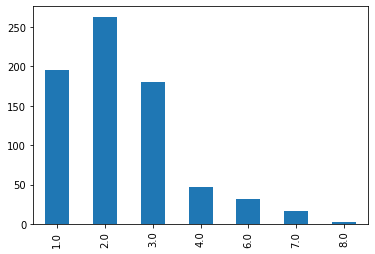

In [55]:
q17txt = pd.read_csv('../data_files/q17_to_categories.txt').set_index('q00')
q17txt.q17c.value_counts().sort_index().plot(kind='bar')
plt.show()

In [56]:
q17txt.head()

,q17c
q00,
2,3.0
3,2.0
4,3.0
5,3.0
6,3.0


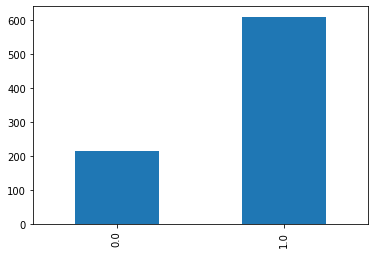

In [57]:
q09txt = pd.read_csv('../data_files/q09_to_categories.txt').set_index('q00')
q09txt.q09b.value_counts().sort_index().plot(kind='bar')
plt.show()

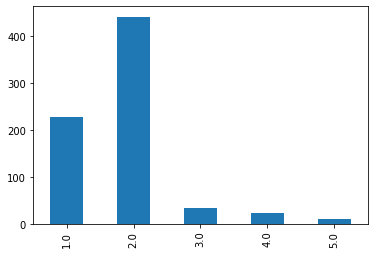

In [58]:
q18txt = pd.read_csv('../data_files/q18_to_categories.txt').set_index('q00')
q18txt.q18b.value_counts().sort_index().plot(kind='bar')
plt.show()

In [59]:
q18txt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 868 entries, 2 to 881
Data columns (total 4 columns):
q18b      737 non-null float64
q18bst    737 non-null float64
q18bmt    737 non-null float64
q18bun    737 non-null float64
dtypes: float64(4)
memory usage: 33.9 KB


In [60]:
pd.DataFrame(q18txt.q18b.value_counts()).sort_index().join(q18txt.groupby(by='q18b').agg('sum'))

,q18b,q18bst,q18bmt,q18bun
1.0,228,228.0,0.0,0.0
2.0,441,0.0,441.0,0.0
3.0,33,0.0,0.0,33.0
4.0,24,21.0,18.0,12.0
5.0,11,0.0,0.0,0.0


In [61]:
q18_cats = {
    "Single-Track": 1,
    "Multi-Track": 2,
    "Unconference": 3,
    "Mixed-Type": 4,
    "No Preference": 5,
}

In [62]:
test17 = pd.read_excel('../kev/mixed_questions_working.xlsx', sheet_name='q17a').set_index('q00')
test17

,q17a,q17b,"q00,q17b"
q00,,,
2,Mid-size conference : 300-500 attendees,3.0,"2,3"
3,Small conference: < 300 attendees,2.0,"3,2"
4,Mid-size conference : 300-500 attendees,3.0,"4,3"
5,Mid-size conference : 300-500 attendees,3.0,"5,3"
6,Mid-size conference : 300-500 attendees,3.0,"6,3"
7,Small conference: < 300 attendees,2.0,"7,2"
8,Mid-size conference : 300-500 attendees,3.0,"8,3"
9,Mid-size conference : 300-500 attendees,3.0,"9,3"
10,Small conference: < 300 attendees,2.0,"10,2"


In [63]:
test18 = pd.read_excel('../kev/mixed_questions_working.xlsx', sheet_name='q18a').set_index('q00')
test18

,q18a,q18b,q18bst,q18bmt,q18bun,"q00,q18b,q18bst,q18bmt,q18bun",q09check,q17check,nullcount
q00,,,,,,,,,
2,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"2,2,0,1,0",0.0,3.0,True
3,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"3,2,0,1,0",1.0,2.0,True
4,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"4,2,0,1,0",NaN,3.0,False
5,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"5,2,0,1,0",1.0,3.0,True
6,Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"6,1,1,0,0",0.0,3.0,True
7,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"7,2,0,1,0",NaN,2.0,False
8,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"8,2,0,1,0",0.0,3.0,True
9,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"9,2,0,1,0",1.0,3.0,True
10,Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"10,1,1,0,0",1.0,2.0,True


In [64]:
test09 = pd.read_excel('../kev/mixed_questions_working.xlsx', sheet_name='q09a').set_index('q00')
test09

,q09a,q09b,"q00,q09b"
q00,,,
2,"No, I was not taught how to conduct research",0.0,"2,0"
3,"Yes, I was taught how to conduct research",1.0,"3,1"
4,NaN,NaN,"4,"
5,My background is engineering. As an engineer I...,1.0,"5,1"
6,"No, I was not taught how to conduct research",0.0,"6,0"
7,NaN,NaN,"7,"
8,"No, I was not taught how to conduct research",0.0,"8,0"
9,"Yes, I was taught how to conduct research",1.0,"9,1"
10,"Yes, I was taught how to conduct research",1.0,"10,1"


In [65]:
testall=test09.join(test17).join(test18)

In [66]:
testall

,q09a,q09b,"q00,q09b",q17a,q17b,"q00,q17b",q18a,q18b,q18bst,q18bmt,q18bun,"q00,q18b,q18bst,q18bmt,q18bun",q09check,q17check,nullcount
q00,,,,,,,,,,,,,,,
2,"No, I was not taught how to conduct research",0.0,"2,0",Mid-size conference : 300-500 attendees,3.0,"2,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"2,2,0,1,0",0.0,3.0,True
3,"Yes, I was taught how to conduct research",1.0,"3,1",Small conference: < 300 attendees,2.0,"3,2",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"3,2,0,1,0",1.0,2.0,True
4,NaN,NaN,"4,",Mid-size conference : 300-500 attendees,3.0,"4,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"4,2,0,1,0",NaN,3.0,False
5,My background is engineering. As an engineer I...,1.0,"5,1",Mid-size conference : 300-500 attendees,3.0,"5,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"5,2,0,1,0",1.0,3.0,True
6,"No, I was not taught how to conduct research",0.0,"6,0",Mid-size conference : 300-500 attendees,3.0,"6,3",Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"6,1,1,0,0",0.0,3.0,True
7,NaN,NaN,"7,",Small conference: < 300 attendees,2.0,"7,2",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"7,2,0,1,0",NaN,2.0,False
8,"No, I was not taught how to conduct research",0.0,"8,0",Mid-size conference : 300-500 attendees,3.0,"8,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"8,2,0,1,0",0.0,3.0,True
9,"Yes, I was taught how to conduct research",1.0,"9,1",Mid-size conference : 300-500 attendees,3.0,"9,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"9,2,0,1,0",1.0,3.0,True
10,"Yes, I was taught how to conduct research",1.0,"10,1",Small conference: < 300 attendees,2.0,"10,2",Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"10,1,1,0,0",1.0,2.0,True


In [67]:
testall.dropna()

,q09a,q09b,"q00,q09b",q17a,q17b,"q00,q17b",q18a,q18b,q18bst,q18bmt,q18bun,"q00,q18b,q18bst,q18bmt,q18bun",q09check,q17check,nullcount
q00,,,,,,,,,,,,,,,
2,"No, I was not taught how to conduct research",0.0,"2,0",Mid-size conference : 300-500 attendees,3.0,"2,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"2,2,0,1,0",0.0,3.0,True
3,"Yes, I was taught how to conduct research",1.0,"3,1",Small conference: < 300 attendees,2.0,"3,2",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"3,2,0,1,0",1.0,2.0,True
5,My background is engineering. As an engineer I...,1.0,"5,1",Mid-size conference : 300-500 attendees,3.0,"5,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"5,2,0,1,0",1.0,3.0,True
6,"No, I was not taught how to conduct research",0.0,"6,0",Mid-size conference : 300-500 attendees,3.0,"6,3",Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"6,1,1,0,0",0.0,3.0,True
8,"No, I was not taught how to conduct research",0.0,"8,0",Mid-size conference : 300-500 attendees,3.0,"8,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"8,2,0,1,0",0.0,3.0,True
9,"Yes, I was taught how to conduct research",1.0,"9,1",Mid-size conference : 300-500 attendees,3.0,"9,3",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"9,2,0,1,0",1.0,3.0,True
10,"Yes, I was taught how to conduct research",1.0,"10,1",Small conference: < 300 attendees,2.0,"10,2",Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"10,1,1,0,0",1.0,2.0,True
11,"Yes, I was taught how to conduct research",1.0,"11,1",Retreat/workshop: < 50 attendees,1.0,"11,1",Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,"11,2,0,1,0",1.0,1.0,True
12,"Yes, I was taught how to conduct research",1.0,"12,1",Mid-size conference : 300-500 attendees,3.0,"12,3",Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,"12,1,1,0,0",1.0,3.0,True


In [68]:
check_idx = (
    datadf[['research_educ', 'ideal_conference_size', 'ideal_structure']]
    .join(testall[['q09a','q09b','q17a','q17b','q18a','q18b','q18bst','q18bmt','q18bun']])
)
check_idx = check_idx[[
    'research_educ', 
    'q09a',
    'q09b',
    'ideal_conference_size', 
    'q17a',
    'q17b',
    'ideal_structure',
    'q18a',
    'q18b',
    'q18bst',
    'q18bmt',
    'q18bun'
]]

In [69]:
check_idx

,research_educ,q09a,q09b,ideal_conference_size,q17a,q17b,ideal_structure,q18a,q18b,q18bst,q18bmt,q18bun
resp_id,,,,,,,,,,,,
284,"sort of, psychology background.","sort of, psychology background.",1.0,depending on the professional values,depending on the professional values,7.0,"any, depending on the values","any, depending on the values",5.0,0.0,0.0,0.0
288,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,I would attend any of these,I would attend any of these,6.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
294,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,It depends - I really enjoyed small conference...,It depends - I really enjoyed small conference...,7.0,It depends,It depends,5.0,0.0,0.0,0.0
281,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,Large conference: 500+ attendees,Large conference: 500+ attendees,4.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
280,"No, I was not taught how to conduct research","No, I was not taught how to conduct research",0.0,Large conference: 500+ attendees,Large conference: 500+ attendees,4.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
295,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,Mid-size conference : 300-500 attendees,Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
291,"No, I was not taught how to conduct research","No, I was not taught how to conduct research",0.0,Mid-size conference : 300-500 attendees,Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
290,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,Mid-size conference : 300-500 attendees,Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0
296,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,Retreat/workshop: < 50 attendees,Retreat/workshop: < 50 attendees,1.0,Single-track: All attendees experience the sam...,Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0


In [70]:
check_idx['q09ok'] = check_idx['research_educ']==check_idx['q09a']
check_idx[check_idx.q09ok==False]

,research_educ,q09a,q09b,ideal_conference_size,q17a,q17b,ideal_structure,q18a,q18b,q18bst,q18bmt,q18bun,q09ok
resp_id,,,,,,,,,,,,,
827,Yes,NaN,NaN,Small conference: < 300 attendees,Small conference: < 300 attendees,2.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
812,NaN,NaN,NaN,Small conference: < 300 attendees,Small conference: < 300 attendees,2.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
806,Yes,NaN,NaN,Small conference: < 300 attendees,Small conference: < 300 attendees,2.0,Single-track: All attendees experience the sam...,Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,False
775,NaN,NaN,NaN,Small conference: < 300 attendees,Small conference: < 300 attendees,2.0,Single-track: All attendees experience the sam...,Single-track: All attendees experience the sam...,1.0,1.0,0.0,0.0,False
722,NaN,NaN,NaN,Retreat/workshop: < 50 attendees,Retreat/workshop: < 50 attendees,1.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
683,Yes,NaN,NaN,Large conference: 500+ attendees,Large conference: 500+ attendees,4.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
679,Yes,NaN,NaN,Mid-size conference : 300-500 attendees,Mid-size conference : 300-500 attendees,3.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
614,Yes,NaN,NaN,Small conference: < 300 attendees,Small conference: < 300 attendees,2.0,Multi-track: Every attendee chooses their own ...,Multi-track: Every attendee chooses their own ...,2.0,0.0,1.0,0.0,False
581,Yes,NaN,NaN,Mid-size conference : 300-500 attendees,Mid-size conference : 300-500 attendees,3.0,Workshops you sign up for that are included in...,Workshops you sign up for that are included in...,5.0,0.0,0.0,0.0,False


In [71]:
check_idx['q17ok'] = check_idx['ideal_conference_size']==check_idx['q17a']
check_idx[check_idx.q17ok==False]

,research_educ,q09a,q09b,ideal_conference_size,q17a,q17b,ideal_structure,q18a,q18b,q18bst,q18bmt,q18bun,q09ok,q17ok
resp_id,,,,,,,,,,,,,,
293,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
289,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
285,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
820,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
816,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
813,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
810,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
805,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False
803,University studies in sociological / statistic...,University studies in sociological / statistic...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False


In [72]:
check_idx['q18ok'] = check_idx['ideal_structure']==check_idx['q18a']
check_idx[check_idx.q18ok==False]

,research_educ,q09a,q09b,ideal_conference_size,q17a,q17b,ideal_structure,q18a,q18b,q18bst,q18bmt,q18bun,q09ok,q17ok,q18ok
resp_id,,,,,,,,,,,,,,,
293,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
289,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
285,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
820,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
816,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
813,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
810,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
805,"Yes, I was taught how to conduct research","Yes, I was taught how to conduct research",1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
803,University studies in sociological / statistic...,University studies in sociological / statistic...,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,False,False
